In [ ]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    if torch.cuda.is_available():
        model = model.to('cuda')

    for epoch in range(num_epochs):

        for images, labels in train_loader:
            if torch.cuda.is_available() :
                images, labels = images.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


class_names = train_dataset.classes
# Map class indices to class names
class_names_dict = {i: class_names[i] for i in range(len(class_names))}

def show_images_with_class_names(images, true_labels, predicted_labels, class_names_dict, num_rows=4, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            image = images[index].permute(1, 2, 0).squeeze().cpu().numpy()
            true_label = true_labels[index].item()
            predicted_label = predicted_labels[index].item()

            true_class_name = class_names_dict[true_label]
            predicted_class_name = class_names_dict[predicted_label]

            axes[i, j].imshow((image + 1) / 2)  # Rescale pixel values to [0, 1]
            axes[i, j].set_title(f'Model Prediction: {predicted_class_name}\nActual Class: {true_class_name}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_and_display(model, data_loader, class_names_dict, device='cuda'):
    model.eval()

    images, true_labels, predicted_labels, misclassified_indices = [], [], [], []

    with torch.no_grad():
        correct = 0
        total = 0

        for batch_images, batch_labels in data_loader:
            if torch.cuda.is_available() and device == 'cuda':
                batch_images = batch_images.to('cuda')
                batch_labels = batch_labels.to('cuda')

            outputs = model(batch_images)

            _, predicted = torch.max(outputs.data, 1)

            images.append(batch_images.cpu())
            true_labels.append(batch_labels.cpu())
            predicted_labels.append(predicted.cpu())

            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

        images = torch.cat(images, dim=0)
        true_labels = torch.cat(true_labels, dim=0)
        predicted_labels = torch.cat(predicted_labels, dim=0)

        # Finding misclassified indices
        misclassified_indices = (predicted_labels != true_labels).nonzero().squeeze().cpu().numpy()

        misclassified_images = images[misclassified_indices]
        misclassified_true_labels = true_labels[misclassified_indices]
        misclassified_predicted_labels = predicted_labels[misclassified_indices]

        print("Correctly Classified Images:")
        show_images_with_class_names(images, true_labels, predicted_labels, class_names_dict)

        print("Misclassified Images:")
        show_images_with_class_names(misclassified_images, misclassified_true_labels, misclassified_predicted_labels, class_names_dict)



In [ ]:
# Let's start off with a simple model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(-1, 128 * 8 * 8)

        x = self.relu3(self.fc1(x))
        x = self.fc2(x)

        return x

model = SimpleCNN()


Epoch [1/10], Loss: 0.9860
Epoch [2/10], Loss: 0.8240
Epoch [3/10], Loss: 0.6809
Epoch [4/10], Loss: 0.6613
Epoch [5/10], Loss: 0.6450
Epoch [6/10], Loss: 0.4568
Epoch [7/10], Loss: 0.4437
Epoch [8/10], Loss: 0.2782
Epoch [9/10], Loss: 0.2650
Epoch [10/10], Loss: 0.1844
Test Accuracy: 74.22%
Correctly Classified Images:


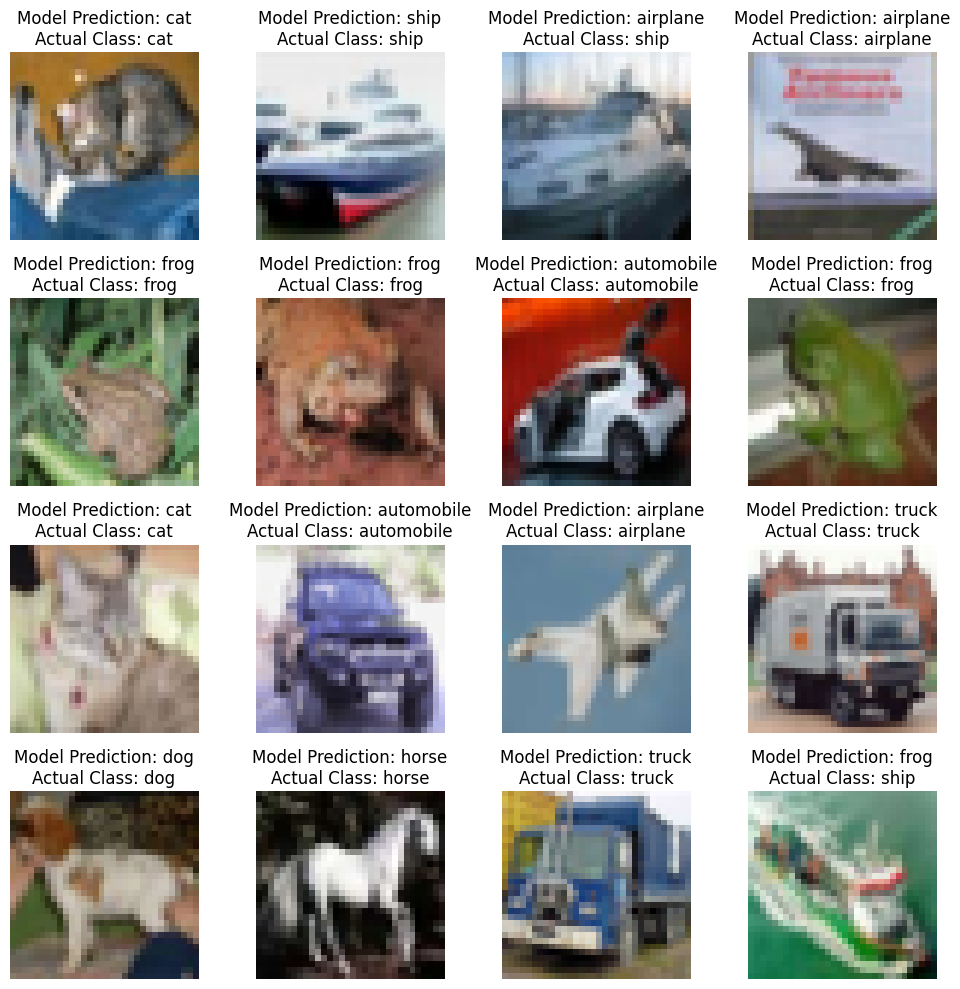

Misclassified Images:


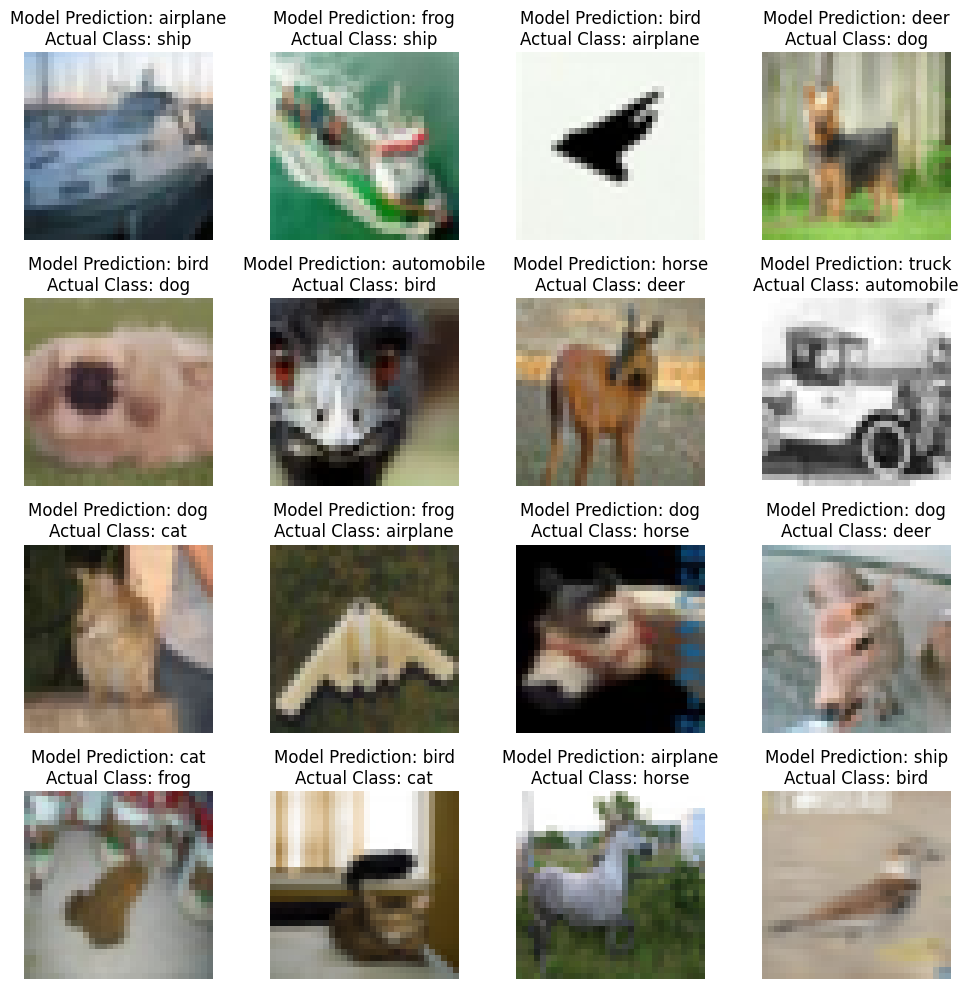

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=2)
evaluate_and_display(model, test_loader, class_names_dict)

In [ ]:
import torch.nn as nn

# Now let's try a more complex model for this problem
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.relu7 = nn.ReLU()
        self.fc2 = nn.Linear(4096, 4096)
        self.relu8 = nn.ReLU()
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)

        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool2(x)

        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.pool3(x)

        x = x.view(-1, 512 * 4 * 4)

        x = self.relu7(self.fc1(x))
        x = self.relu8(self.fc2(x))
        x = self.fc3(x)

        return x

model = VGGNet()

Epoch [1/10], Loss: 1.5520
Epoch [2/10], Loss: 1.1986
Epoch [3/10], Loss: 0.8986
Epoch [4/10], Loss: 0.6184
Epoch [5/10], Loss: 0.5596
Epoch [6/10], Loss: 0.5769
Epoch [7/10], Loss: 0.3913
Epoch [8/10], Loss: 0.2414
Epoch [9/10], Loss: 0.1547
Epoch [10/10], Loss: 0.1640
Test Accuracy: 79.20%
Correctly Classified Images:


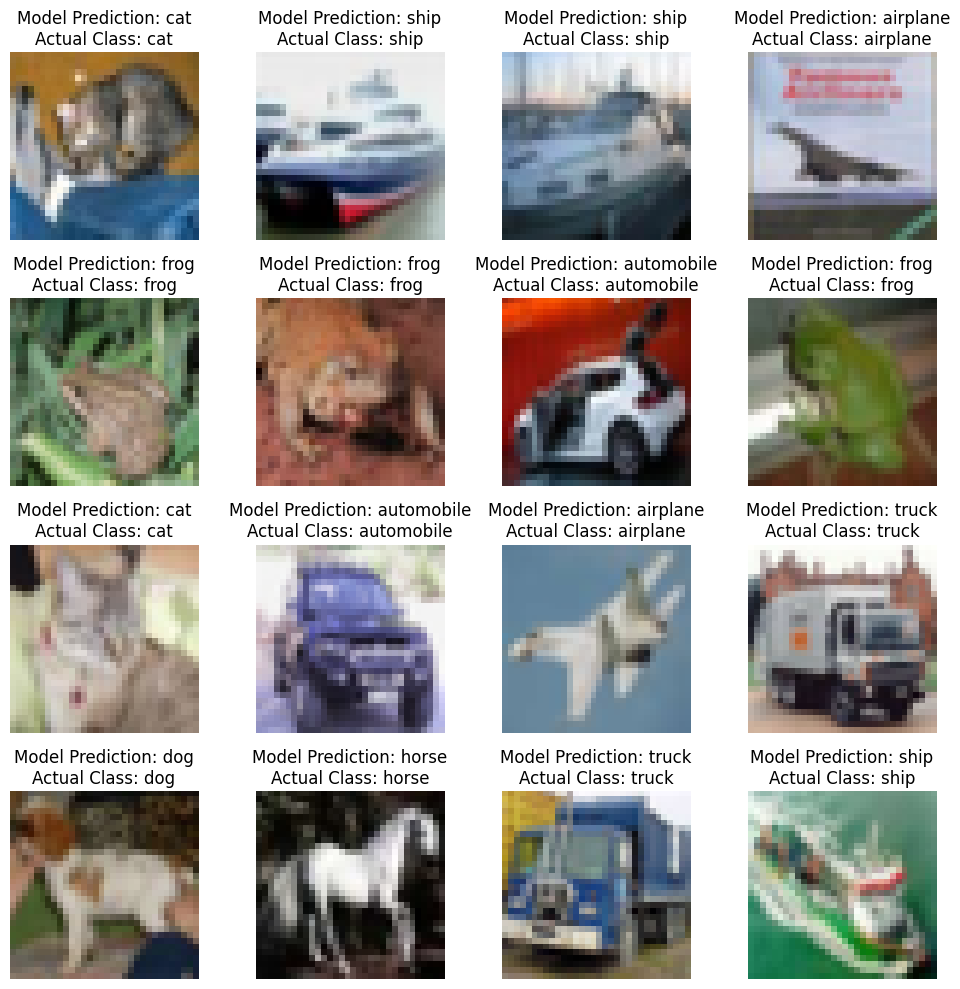

Misclassified Images:


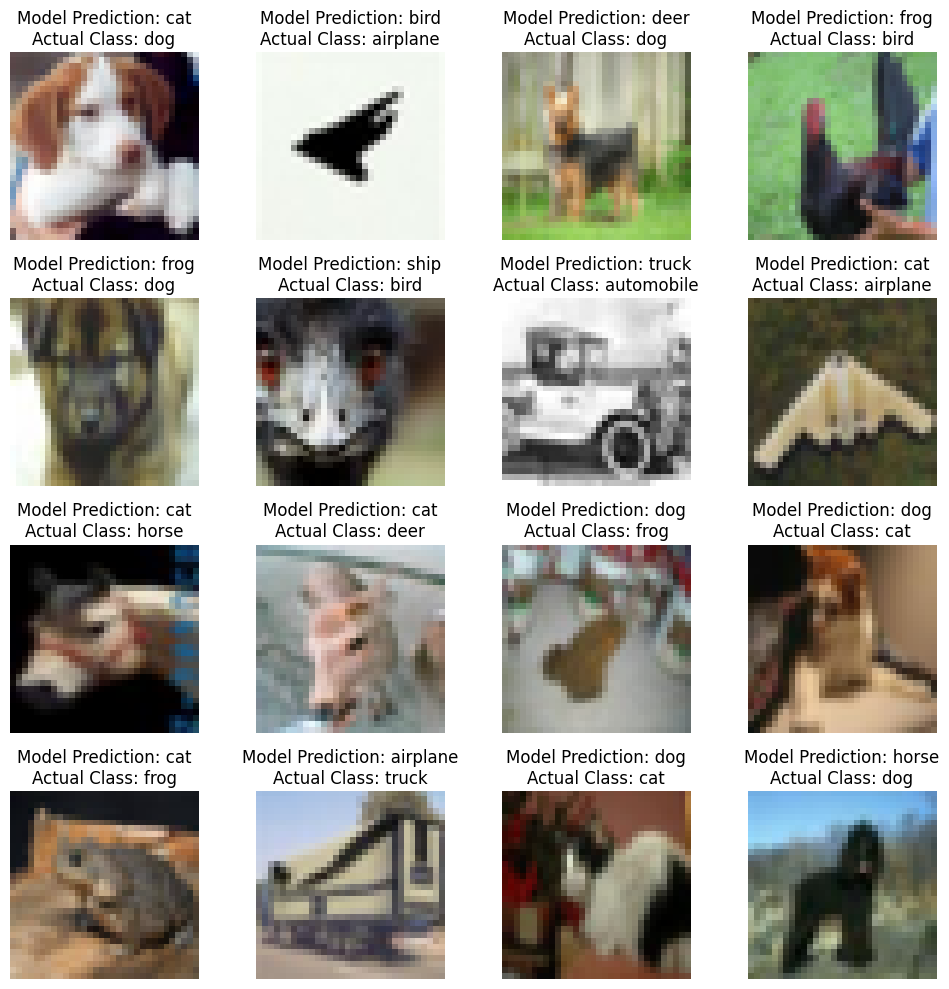

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=2)
evaluate_and_display(model, test_loader, class_names_dict)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2, 2])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True, num_workers=2)
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=2)
evaluate_and_display(model, test_loader, class_names_dict)

Epoch [1/10], Loss: 1.2754
Epoch [2/10], Loss: 0.9554
Epoch [3/10], Loss: 0.7642


In [ ]:
from torch.utils.data import DataLoader, random_split

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=2)

if torch.cuda.is_available():
    model = model.to('cuda')

num_epochs = 10

for epoch in range(num_epochs):

    model.train()
    for images, labels in train_loader:
        if torch.cuda.is_available():
            images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}')


Epoch [1/10], Loss: 0.5176, Val Loss: 0.7204, Val Accuracy: 77.62%
Epoch [2/10], Loss: 0.3349, Val Loss: 0.7859, Val Accuracy: 77.63%
Epoch [3/10], Loss: 0.3013, Val Loss: 0.8279, Val Accuracy: 77.16%
Epoch [4/10], Loss: 0.3649, Val Loss: 0.8861, Val Accuracy: 77.38%
Epoch [5/10], Loss: 0.1855, Val Loss: 1.0476, Val Accuracy: 76.91%
Epoch [6/10], Loss: 0.1272, Val Loss: 1.0563, Val Accuracy: 77.91%
Epoch [7/10], Loss: 0.0425, Val Loss: 1.0079, Val Accuracy: 78.66%
Epoch [8/10], Loss: 0.0559, Val Loss: 1.0501, Val Accuracy: 78.01%
Epoch [9/10], Loss: 0.0869, Val Loss: 1.2176, Val Accuracy: 78.38%
Epoch [10/10], Loss: 0.1240, Val Loss: 1.1834, Val Accuracy: 78.21%
